# Diagramy Voronoi

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

FIG_EPS = 0.1

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (round(event.xdata,8), round(event.ydata,8))
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < FIG_EPS:
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        if self.scenes[self.i].circle is not None:
            self.ax.add_patch(self.scenes[self.i].circle)
        plot_lines=[]
        for arc in self.scenes[self.i].arcs:
            plot_line = arc.get_plot(self.scenes[self.i].x, self.scenes[self.i].y)
            if plot_line is not None:
                plot_lines.append(plot_line)
        if len(plot_lines) > 0:
            self.ax.plot(self.scenes[self.i].x, np.min(plot_lines, axis=0), color='k')
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[], arcs=[], x=None, y=None, circ=None):
        self.points=points
        self.lines=lines
        self.circle=circ
        self.arcs=arcs
        self.x=x
        self.y=y

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_rects(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

In [3]:
%matplotlib notebook

In [4]:
def randomFirst(n, left, right):
    pts = []
    seed(1)
    for i in range(0,n):
        pts.append((round(left+random()*(right-left),8),round(left+random()*(right-left),8)))
    return pts

# Fortune's algorithm

# Data Structures

In [5]:
# import odpowiednich bibliotek
import numpy as np
import math
from queue import PriorityQueue
import copy,time
from random import seed, random

In [6]:
# klasa symbolizująca punkt 
class Coordinate:
    def __init__(self, x, y):
        self.x=x
        self.y=y

    def __str__(self):
        return "("+str(self.x)+','+str(self.y)+')'

In [7]:
# klasa symbolizująca parabolę
class Arc:
    def __init__(self, origin, circle_event=None):
        self.origin = origin
        self.circle_event = circle_event

    def __str__(self):
        return "Arc with origin in " + str(self.origin)
    
    # metoda zwracająca liste [y1,y2,...] pozwalajacą narysować parabolę
    def get_plot(self, x, sweepline):
        i = self.origin

        if i.y - sweepline == 0:
            return None

        a = 2 * (i.y - sweepline)
        b = (x ** 2 - 2 * i.x * x + i.x ** 2 + i.y ** 2 - sweepline ** 2)
        y = b/a

        return y

In [8]:
# klasa symbolizująca breakpoint
class Breakpoint:
    def __init__(self, breakpoint, edge=None):
        self.breakpoint = breakpoint
        self.edge = edge

    def __str__(self):
        return "Breakpoint "+str(self.breakpoint[0]) + " and " + str(self.breakpoint[1])
    
    # metoda sprawdzająca czy istnieje punkt przecięcia
    def does_intersect(self):
        a, b = self.breakpoint
        return not (a.y == b.y and b.x < a.x)

    # metoda znajdująca punkt przecięcia, https://www.cs.hmc.edu/~mbrubeck/voronoi.html
    def get_intersection(self, l, max_y=None):
        i, j = self.breakpoint
        result = Coordinate(0,0)
        p=i

        a = i.x
        b = i.y
        c = j.x
        d = j.y
        u = 2*(b - l)
        v = 2*(d - l)

        if i.y == j.y:
            result.x = (i.x + j.x) / 2

            if j.x < i.x:
                result.y = max_y or float('inf')
                return result

        elif i.y == l:
            result.x = i.x
            p = j
        elif j.y == l:
            result.x = j.x
        else:
            x = -(math.sqrt(
                v * (a ** 2 * u - 2 * a * c * u + b ** 2 * (u - v) + c ** 2 * u) + d ** 2 * u * (v - u) + l ** 2 * (
                        u - v) ** 2) + a * v - c * u) / (u - v)
            result.x = x

        a = p.x
        b = p.y
        x = result.x
        u = 2 * (b - l)

        if u == 0:
            result.y = float("inf")
            return result

        result.y = 1 / u * (x ** 2 - 2 * a * x + a ** 2 + b ** 2 - l ** 2)
        return result

In [9]:
# klasa symbolizująca półkrawędź
class HalfEdge:
    # origin może być zarówno obiektem klasy Vertex jak i Breakpoint
    def __init__(self, incident_point, twin=None, origin=None):
        self.origin = origin
        self.incident_point = incident_point
        self._twin = None
        self.twin = twin
        self.next = None
        self.prev = None
        self.removed = False

    def __str__(self):
        return "HalfEdge. Origin "+str(self.origin) + ", incident point " + str(self.incident_point)
    
    # metoda ustawia wskaźnik next
    def set_next(self, next):
        if next:
            next.prev = self
        self.next = next
    
    # metoda zwraca wierzchołek półkrawędzi
    def get_origin(self, y=None, max_y=None):
        if isinstance(self.origin, Vertex):
            return self.origin.position

        if y is not None:
            return self.origin.get_intersection(y,max_y)

        return None

    # getter i setter dla pola _twin
    @property
    def twin(self):
        return self._twin

    @twin.setter
    def twin(self, twin):

        if twin is not None:
            twin._twin = self

        self._twin = twin

In [10]:
# klasa symbolizująca punkt, dziedziczy z Coordinate
class Point(Coordinate):
    def __init__(self, x=None, y=None, first_edge=None):
        super().__init__(x, y)
        self.first_edge = first_edge

    def __str__(self):
        return "Point ("+str(self.x)+","+str(self.y)+")"

In [11]:
# klasa symbolizująca wielokąt
class Polygon:
    def __init__(self, tuples):
        self.points = [Coordinate(x, y) for x, y in tuples]
        self.min_y = min([p.y for p in self.points])
        self.min_x = min([p.x for p in self.points])
        self.max_y = max([p.y for p in self.points])
        self.max_x = max([p.x for p in self.points])
        self.center = Coordinate((self.max_x + self.min_x) / 2, (self.max_y + self.min_y) / 2)
        self.points = self.order_points(self.points)
        self.polygon_vertices = []
        for point in self.points:
            self.polygon_vertices.append(Vertex(point=point))
    
    # metoda ustawiająca punkty w porządku zgodnym ze wskazówkami zegara
    def order_points(self, points):
        clockwise = sorted(points, key=lambda point: (-180 - Math.calculate_angle(point, self.center)) % 360)
        return clockwise
    
    # metoda zwracająca najbliższy wierzchołek do podanego
    def get_closest_point(self,position, points):
        distances = [Math.distance(position, p) for p in points]
        index = np.argmin(distances)
        return points[index]

    # metoda dokańczająca lub skracająca linie by były zgodne z obramowaniem
    def finish_edges(self, edges, draw_lines, steps, points, draw_vertices):
        resulting_edges = []
        for edge in edges:
            if edge.get_origin() is None or not self.inside(edge.get_origin()):
                self.finish_edge(edge)

            if edge.twin.get_origin() is None or not self.inside(edge.twin.get_origin()):
                self.finish_edge(edge.twin)
            if edge.get_origin() is not None and edge.twin.get_origin() is not None:
                resulting_edges.append(edge)
                start=edge.get_origin()
                end=edge.twin.get_origin()
                draw_lines.append([(start.x,start.y),(end.x,end.y)])
                steps.append(Scene([PointsCollection(copy.deepcopy(points),color='b'),PointsCollection(copy.deepcopy(draw_vertices),color='c')],[LinesCollection(copy.deepcopy(draw_lines),color='c')]))  

            else:
                self.delete_edge(edge)

        return resulting_edges
    
    # metoda usuwająca linię
    def delete_edge(self,edge):
        prev_edge = edge.prev
        next_edge = edge.next

        if prev_edge:
            prev_edge.set_next(next_edge)

        if next_edge:
            next_edge.twin.set_next(prev_edge)


        if edge.incident_point.first_edge == edge:
            if prev_edge:
                edge.incident_point.first_edge = prev_edge
            elif next_edge:
                edge.incident_point.first_edge = next_edge

        if edge.twin.incident_point.first_edge == edge.twin:
            if prev_edge:
                edge.twin.incident_point.first_edge = prev_edge.twin
            elif next_edge:
                edge.twin.incident_point.first_edge = next_edge.twin

    # metoda kończąca linię 
    def finish_edge(self, edge):
        start = edge.get_origin(y=2*(self.min_y - self.max_y), max_y=self.max_y)

        end = edge.twin.get_origin(y=self.min_y - self.max_y, max_y=self.max_y)

        point = self.get_intersection_point(end, start)

        v = Vertex(point=point)
        v.incident_edges.append(edge)
        edge.origin = v
        self.polygon_vertices.append(v)

        return edge
    
    # metoda sprawdzająca czy punkt leży wewnątrz obramowania
    def inside(self, point):
        vertices = self.points + self.points[0:1]
        x = point.x
        y = point.y
        inside = False

        for i in range(0, len(vertices) - 1):
            j = i + 1
            xi = vertices[i].x
            yi = vertices[i].y
            xj = vertices[j].x
            yj = vertices[j].y

            intersect = ((yi > y) != (yj > y)) and (x < (xj - xi) * (y - yi) / (yj - yi) + xi)
            if intersect:
                inside = not inside

        return inside

    # metoda znajdująca punkt przecięcia z obramowaniem
    def get_intersection_point(self, orig, end):
        p = self.points + [self.points[0]]
        points = []

        point = None

        for i in range(0, len(p) - 1):
            intersection_point = Math.get_intersection(orig, end, p[i], p[i + 1])
            if intersection_point:
                points.append(intersection_point)

        if not points:
            return None

        max_distance = Math.distance(orig, end)

        if points:
            distances = [Math.distance(orig, p) for p in points]
            distances = [i for i in distances if i <= max_distance]
            if distances:
                point = points[np.argmax(distances)]

        return point

In [12]:
# klasa symbolizująca wierzchołek
class Vertex:
    def __init__(self, incident_edges=None, point=None):
        if incident_edges is None:
            incident_edges = []

        self.incident_edges = incident_edges

        self.position = point

    def __str__(self):
        return "Vertex " +str(self.point)

# Math

In [13]:
# klasa Math zawierająca pomocne metody do obliczeń
class Math:
    # metoda obliczająca odległość
    @staticmethod
    def distance(point_a, point_b):
        x1 = point_a.x
        x2 = point_b.x
        y1 = point_a.y
        y2 = point_b.y

        return np.sqrt((x2 - x1) ** 2 + (y2 - y1)**2)
    
    # metoda obliczająca długość wektora
    @staticmethod
    def magnitude(vector):
        return np.sqrt(np.dot(np.array(vector), np.array(vector)))

    # metoda zwracająca normę wektora
    @staticmethod
    def norm(vector):
        if Math.magnitude(np.array(vector)) == 0:
            return np.array(vector)
        return np.array(vector) / Math.magnitude(np.array(vector))

    # metoda zwracająca punkt przecięcia odcinkow jeśli istnieje
    @staticmethod
    def line_ray_intersection_point(ray_orig, ray_end, point_1, point_2):
        orig = np.array(ray_orig, dtype=np.float)
        end = np.array(ray_end)
        direction = np.array(Math.norm(end - orig), dtype=np.float)
        point_1 = np.array(point_1, dtype=np.float)
        point_2 = np.array(point_2, dtype=np.float)

        v1 = orig - point_1
        v2 = point_2 - point_1
        v3 = np.array([-direction[1], direction[0]])

        if np.dot(v2, v3) == 0:
            return []

        t1 = np.cross(v2, v1) / np.dot(v2, v3)
        t2 = np.dot(v1, v3) / np.dot(v2, v3)

        if t1 > 0.0 and 0.0 <= t2 <= 1.0:
            return [orig + t1 * direction]
        return []

    # metoda zwracajaca punkt przeciecia odcinkow jesli istnieje 
    @staticmethod
    def get_intersection(orig, end, p1, p2):
        if not orig or not end:
            return None

        point = Math.line_ray_intersection_point([orig.x, orig.y], [end.x, end.y], [p1.x, p1.y], [p2.x, p2.y])

        if len(point) == 0:
            return None

        return Coordinate(point[0][0], point[0][1])

    # metoda obliczająca kąt 
    @staticmethod
    def calculate_angle(point, center):
        dx = point.x - center.x
        dy = point.y - center.y
        return np.math.degrees(np.math.atan2(dy, dx)) % 360

    # metoda sprawdzająca czy punkty są ułożone zgodnie z kierunkiem ruchu wskazówek zegara
    @staticmethod
    def check_clockwise(a, b, c, center):
        angle_1 = Math.calculate_angle(a, center)
        angle_2 = Math.calculate_angle(b, center)
        angle_3 = Math.calculate_angle(c, center)

        counter_clockwise = (angle_3 - angle_1) % 360 > (angle_3 - angle_2) % 360

        if counter_clockwise:
            return False

        return True

# Events Structures

In [14]:
# klasa symbolizująca zdarzenie
class Event:
    
    def __init__(self, circle_event=False):
        self.circle_event=circle_event
    
    # obiekt mniejszy gdy większa współrzędna y, w przypadku remisu mniejsza współrzędna x
    def __lt__(self, other):
        if self.y == other.y and self.x == other.x:
            return self.circle_event and not other.circle_event

        if self.y == other.y:
            return self.x < other.x

        return self.y > other.y
    
    # obiekty równe, gdy równe współrzędne
    def __eq__(self, other):
        if other is None:
            return None
        return self.y == other.y and self.x == other.x

    def __ne__(self, other):
        return not self.__eq__(other)

In [15]:
# klasa symbolizująca zdarzenie kołowe, dziedziczy z klasy Event
class CircleEvent(Event):
    def __init__(self, center, radius, arc_node, point_triple=None, arc_triple=None):
        super().__init__(True)
        self.center = center
        self.radius = radius
        self.arc_pointer = arc_node
        self.is_valid = True
        self.point_triple = point_triple
        self.arc_triple = arc_triple

    def __str__(self):
        return "CircleEvent "+str(self.point_triple)+" Radius "+str(self.center.y - self.radius)

    # metoda do zaznaczania "fałszywych" zdarzeń
    def remove(self):
        self.is_valid = False
        return self

    @property
    def x(self):
        return self.center.x

    @property
    def y(self):
        return self.center.y-self.radius
    
    # metoda tworząca nowe zdarzenie kołowe 
    @staticmethod
    def create_circle_event(left_node, middle_node, right_node, sweep_line):

        if left_node is None or right_node is None or middle_node is None:
            return None

        left_arc = left_node.get_value()
        middle_arc = middle_node.get_value()
        right_arc = right_node.get_value()

        a, b, c = left_arc.origin, middle_arc.origin, right_arc.origin

        if CircleEvent.create_circle(a, b, c):

            x, y, radius = CircleEvent.create_circle(a, b, c)

            return CircleEvent(Coordinate(x, y),radius,middle_node,(a, b, c),(left_arc, middle_arc, right_arc))

        return None

    # metoda tworząca koło przy pomocy 3 punktów
    @staticmethod
    def create_circle(a, b, c):

        a, b, c = sorted((a, b, c), key=lambda item: item.x)

        A = b.x - a.x
        B = b.y - a.y
        C = c.x - a.x
        D = c.y - a.y
        E = (b.x - a.x) * (a.x + b.x) + (b.y - a.y) * (a.y + b.y)
        F = (c.x - a.x) * (a.x + c.x) + (c.y - a.y) * (a.y + c.y)
        G = 2 * ((b.x - a.x) * (c.y - b.y) - (b.y - a.y) * (c.x - b.x))

        if G == 0:
            return False

        x = (D * E - B * F) / G
        y = (A * F - C * E) / G
        radius = (math.sqrt(math.pow(a.x - x, 2) + math.pow(a.y - y, 2)))

        return float(x), float(y), float(radius)

In [16]:
# klasa symbolizująca zdarzenie punktowe, dziedziczy po Event
class SiteEvent(Event):
    def __init__(self, point):
        super().__init__()
        self.point = point

    @property
    def x(self):
        return self.point.x

    @property
    def y(self):
        return self.point.y

    def __str__(self):
        return "SiteEvent "+str(self.point)

# Tree

In [17]:
class Node:
    def __init__(self, data):
        self.data = data
        self._left = None
        self._right = None
        self._height = None
        self.parent = None

    def __str__(self):
        return "Node "+str(self.data)+" Left "+str(self.left)+" right "+str(self.right)

    @property
    def left(self):
        return self._left

    @property
    def right(self):
        return self._right

    @property
    def grandparent(self):
        if self.parent is None or self.parent.parent is None:
            return None
        return self.parent.parent

    def get_key(self, **kwargs):
        return self.data

    def get_value(self, **kwargs):
        return self.data

    @left.setter
    def left(self, node):

        if node is not None:
            node.parent = self

        self._left = node

    @right.setter
    def right(self, node):

        if node is not None:
            node.parent = self

        self._right = node

    @property
    def height(self):
        if self._height is None:
            self._height = self.calculate_height()
        return self._height

    @property
    def balance(self):
        left_height = self.left.height if self.left is not None else 0
        right_height = self.right.height if self.right is not None else 0
        return left_height - right_height

    def calculate_height(self):
        left_height = self.left.height if self.left is not None else 0
        right_height = self.right.height if self.right is not None else 0
        height = 1 + max(left_height, right_height)
        return height

    def update_height(self):
        self._height = self.calculate_height()

    def update_heights(self):
        self.update_height()

        if self.parent is not None:
            self.parent.update_heights()

    def is_left_child(self):
        if self.parent is None:
            return False
        return self.parent.left == self

    def is_right_child(self):
        if self.parent is None:
            return False
        return self.parent.right == self

    def is_leaf(self):
        return self.left is None and self.right is None

    def minimum(self):
        current = self
        while current.left is not None:
            current = current.left
        return current

    def maximum(self):
        current = self
        while current.right is not None:
            current = current.right
        return current

    @property
    def successor(self):
        if self.right is not None:
            return self.right.minimum()

        current = self
        while current.is_right_child():
            current = current.parent

        if current.parent is None or current.parent.right is None:
            return None

        return current.parent.right.minimum()

    @property
    def predecessor(self):
        if self.left is not None:
            return self.left.maximum()

        current = self
        while current.is_left_child():
            current = current.parent

        if current.parent is None or current.parent.left is None:
            return None

        return current.parent.left.maximum()

    def replace_leaf(self, replacement, root):
        if replacement is not None:
            replacement.parent = self.parent

        if self.is_left_child():
            self.parent.left = replacement

        elif self.is_right_child():
            self.parent.right = replacement

        else:
            root = replacement

        if replacement is not None:
            replacement.update_heights()

        elif self.parent is not None:
            self.parent.update_heights()

        return root


class LeafNode(Node):
    def __init__(self, data="Arc"):
        super().__init__(data)

    def __str__(self):
        return "Leaf "+str(self.data)+" Left "+str(self.left)+" right "+str(self.right)

    def get_key(self, sweep_line=None):
        return self.data.origin.x

    def get_value(self, **kwargs):
        return self.data

class InternalNode(Node):
    def __init__(self, data="Breakpoint"):
        super().__init__(data)

    def __str__(self):
        return "Internal "+str(self.data)+" Left "+str(self.left)+" right "+str(self.right)

    def get_key(self, sweep_line=None):
        return self.data.get_intersection(sweep_line).x

    def get_value(self, **kwargs):
        return self.data

In [18]:
class Tree:
    @staticmethod
    def find_value(root, query, compare=lambda x, y: x == y, **kwargs):
        key = query.get_key(**kwargs)
        node = root
        while node is not None:
            if key == node.get_key(**kwargs):

                if compare(node.data, query.data):
                    return node

                left = Tree.find_value(node.left, query, compare, **kwargs)
                if left is None:
                    right = Tree.find_value(node.right, query, compare, **kwargs)
                    return right

                return left

            elif key < node.get_key(**kwargs):
                node = node.left
            else:
                node = node.right

        return node

    @staticmethod
    def find_leaf_node(root, key, **kwargs):
        node = root
        while node is not None:

            if node.is_leaf():
                return node

            elif key == node.get_key(**kwargs) and not node.is_leaf():

                if node.left is not None:
                    return node.left.maximum()

                return node.right.minimum()

            elif key < node.get_key(**kwargs):
                node = node.left
            else:
                node = node.right

        return node
    
    @staticmethod
    def balance_and_propagate(node):
        node = Tree.balance(node)

        if node.parent is None:
            return node

        return Tree.balance_and_propagate(node.parent)

    @staticmethod
    def balance(node):
        if node.balance > 1 and node.left.balance >= 0:
            return Tree.rotate_right(node)

        if node.balance < -1 and node.right.balance <= 0:
            return Tree.rotate_left(node)

        if node.balance > 1 and node.left.balance < 0:
            node.left = Tree.rotate_left(node.left)
            return Tree.rotate_right(node)

        if node.balance < -1 and node.right.balance > 0:
            node.right = Tree.rotate_right(node.right)
            return Tree.rotate_left(node)

        return node

    @staticmethod
    def rotate_left(z):

        grandparent = z.parent
        y = z.right
        T2 = y.left

        y.parent = grandparent

        if grandparent is not None:
            if z.is_left_child():
                grandparent.left = y
            else:
                grandparent.right = y

        y.left = z
        z.right = T2

        z.update_height()
        y.update_height()

        return y

    @staticmethod
    def rotate_right(z):
        grandparent = z.parent
        y = z.left
        T3 = y.right

        y.parent = grandparent

        if grandparent is not None:
            if z.is_left_child():
                grandparent.left = y
            else:
                grandparent.right = y

        y.right = z
        z.left = T3

        z.update_height()
        y.update_height()

        return y

# Actual Algorithm

In [28]:
class Voronoi:
    def __init__(self):
        # Pola do opisu diagramu Voronoi
        self.event_queue = PriorityQueue()
        self.beach_line = None
        self.sweep_line = float("inf")
        self.points = None
        self.edges = []
        self.vertices = []
        
        # Pola umożliwiające wizualizację krok po kroku
        self.x0 = self.x1 = self.y0 = self.y1 = None
        self.bounding_poly = None
        self.draw_arcs = []
        self.draw_points=[]
        self.draw_vertices=[]
        self.used_points=[]
        self.draw_lines=[]
        self.steps=[]
        self.tmp=[]
        self.xfull= None
        
    def initialize(self, points):
        self.points = points
        # Tworzę obramowanie 
        self.x0=min(p.x for p in points)
        self.x1=max(p.x for p in points)
        self.y0=min(p.y for p in points)
        self.y1=max(p.y for p in points)
        dx=(self.x1-self.x0)/4
        dy=(self.y1-self.y0)/4
        self.x0 -= dx
        self.x1 += dx
        self.y0 -= dy
        self.y1 += dy
        self.bounding_poly=Polygon([(self.x0,self.y0),(self.x1,self.y0),(self.x1,self.y1),(self.x0,self.y1),(self.x0,self.y0)])
        
        # xfull odpowiada za szerokość paraboli, dodaje punkty do struktury zdarzeń
        self.xfull=np.linspace(self.bounding_poly.min_x - dy/4, self.bounding_poly.max_x + dy/4, 1000)
        for index, point in enumerate(points):
            site_event = SiteEvent(point=point)
            self.event_queue.put(site_event)
    
    def create_diagram(self, points):
        # Inicjalizuje draw_points, dodaje scene początkową, zmieniam liste tupli na liste obiektów
        self.draw_points=points
        self.tmp=copy.deepcopy(points)
        points = [Point(x, y) for x, y in points]
        
        # Inicjalizuje strukture, zapisuje czas by móc policzyć czas trwania procedury
        time1=time.time()
        self.initialize(points)
        self.draw_lines.append([(self.x0,self.y0),(self.x1,self.y0),(self.x1,self.y1),(self.x0,self.y1),(self.x0,self.y0)])
        self.steps.append(Scene([PointsCollection(self.tmp,color='b')]))
        self.steps.append(Scene([PointsCollection(self.tmp,color='b')],[LinesCollection(copy.deepcopy(self.draw_lines),color='c')]))
        
        # Główna pętla, przechodzi przez wszystkie punkty struktury zdarzeń, dodaje sceny
        index = 0
        genesis_point = None
        while not self.event_queue.empty():
            event = self.event_queue.get()
            genesis_point = genesis_point or event.point

            if isinstance(event, CircleEvent) and event.is_valid:
                self.sweep_line = event.y
                self.steps.append(Scene([PointsCollection(copy.deepcopy(self.draw_points)),PointsCollection(copy.deepcopy(self.used_points),color='g'),PointsCollection(copy.deepcopy(self.tmp),color='b'),PointsCollection(copy.deepcopy(self.draw_vertices),color='c')],[LinesCollection([[(self.x0,event.y),(self.x1,event.y)]]),LinesCollection(copy.deepcopy(self.draw_lines),color='c')],copy.deepcopy(self.draw_arcs),self.xfull,self.sweep_line))  
                self.steps.append(Scene([PointsCollection(copy.deepcopy(self.draw_points)),PointsCollection(copy.deepcopy(self.used_points),color='g'),PointsCollection(copy.deepcopy(self.tmp),color='b'),PointsCollection([(event.center.x,event.center.y-event.radius)],color='r'),PointsCollection([(event.center.x,event.center.y)],color='y'),PointsCollection(copy.deepcopy(self.draw_vertices),color='c')],[LinesCollection([[(self.x0,event.y),(self.x1,event.y)]]),LinesCollection(copy.deepcopy(self.draw_lines),color='c')],copy.deepcopy(self.draw_arcs),self.xfull,self.sweep_line,plt.Circle((event.center.x,event.center.y),event.radius,color='r',fill=False)))

                self.handle_circle_event(event)

            elif isinstance(event, SiteEvent):
                self.sweep_line = event.y
                self.steps.append(Scene([PointsCollection(copy.deepcopy(self.draw_points)),PointsCollection(copy.deepcopy(self.used_points),color='g'),PointsCollection(copy.deepcopy(self.tmp),color='b'),PointsCollection(copy.deepcopy(self.draw_vertices),color='c')],[LinesCollection([[(self.x0,event.y),(self.x1,event.y)]]),LinesCollection(copy.deepcopy(self.draw_lines),color='c')],copy.deepcopy(self.draw_arcs),self.xfull,self.sweep_line))
                self.steps.append(Scene([PointsCollection(copy.deepcopy(self.draw_points)),PointsCollection(copy.deepcopy(self.used_points),color='g'),PointsCollection(copy.deepcopy(self.tmp),color='b'),PointsCollection([(event.x,event.y)],color='r'),PointsCollection(copy.deepcopy(self.draw_vertices),color='c')],[LinesCollection([[(self.x0,event.y),(self.x1,event.y)]]),LinesCollection(copy.deepcopy(self.draw_lines),color='c')],copy.deepcopy(self.draw_arcs),self.xfull,self.sweep_line))
                self.handle_site_event(event)
            self.used_points.append((event.x,event.y))
        
        # Dodaje sceny oraz "zamykam" obramowanie 
        self.steps.append(Scene([PointsCollection(copy.deepcopy(self.used_points),color='g'),PointsCollection(copy.deepcopy(self.tmp),color='b'),PointsCollection(copy.deepcopy(self.draw_vertices),color='c')],[LinesCollection(copy.deepcopy(self.draw_lines),color='c')]))  
        
        self.edges = self.bounding_poly.finish_edges(self.edges, self.draw_lines, self.steps, self.tmp, self.draw_vertices)
        self.steps.append(Scene([PointsCollection(copy.deepcopy(self.tmp),color='b'),PointsCollection(copy.deepcopy(self.draw_vertices),color='c')],[LinesCollection(copy.deepcopy(self.draw_lines),color='c')]))  
        
        # Obliczam czas działania programu, zwracam sceny
        time2=time.time()
        print("It took "+str(time2-time1)+"s time")
        return self.steps


    def handle_site_event(self, event):
        # Tworzę nową parabolę
        new_point = event.point
        new_arc = Arc(origin=new_point)
        self.draw_arcs.append(new_arc)
        
        # Jeśli drzewo jest puste, wsadzam nowy element i wracam
        if self.beach_line is None:
            self.beach_line = LeafNode(new_arc)
            return
        
        # Znajduje parabole powyżej obecnie przetwarzanego punktu
        arc_node_above_point = Tree.find_leaf_node(self.beach_line, key=new_point.x, sweep_line=self.sweep_line)
        arc_above_point = arc_node_above_point.get_value()

        # Usuwam "fałszywe" punkty zdarzeń (koła)
        if arc_above_point.circle_event is not None:
            arc_above_point.circle_event.remove()

        # Rozbijam liść na odpowiednie poddrzewo
        point_i = new_point
        point_j = arc_above_point.origin
        breakpoint_left = Breakpoint((point_j, point_i))
        breakpoint_right = Breakpoint((point_i, point_j))
        
        root = InternalNode(breakpoint_left)
        root.left = LeafNode(Arc(origin=point_j, circle_event=None))

        # Prawy Breakpoint ląduje w drzewie tylko jeżeli istnieje punkt przecięcia
        if breakpoint_right.does_intersect():
            root.right = InternalNode(breakpoint_right)
            root.right.left = LeafNode(new_arc)
            root.right.right = LeafNode(Arc(origin=point_j, circle_event=None))
        else:
            root.right = LeafNode(new_arc)

        self.beach_line = arc_node_above_point.replace_leaf(replacement=root, root=self.beach_line)

        # Tworzę odpowiednie półkrawędzie
        A, B = point_j, point_i
        AB = breakpoint_left
        BA = breakpoint_right
        
        AB.edge = HalfEdge(B, origin=AB)
        BA.edge = HalfEdge(A, origin=BA, twin=AB.edge)

        self.edges.append(AB.edge)

        B.first_edge = B.first_edge or AB.edge
        A.first_edge = A.first_edge or BA.edge

        # Sprawdzam czy istnieje punkt przecięcia
        if not breakpoint_right.does_intersect():
            return

        node_a, node_b, node_c = root.left.predecessor, root.left, root.right.left
        node_c, node_d, node_e = node_c, root.right.right, root.right.right.successor

        self.check_circles((node_a, node_b, node_c), (node_c, node_d, node_e))
        
        # Naprawa drzewa
        self.beach_line = Tree.balance_and_propagate(root)

    def handle_circle_event(self, event):
        # Usuwam odpowiedni liśc drzewa reprezentujący parabole 
        arc_node = event.arc_pointer
        predecessor = arc_node.predecessor
        successor = arc_node.successor
        
        # Aktualizuje breakpointy
        self.beach_line, updated, removed, left, right = self.update_breakpoints(
            self.beach_line, self.sweep_line, arc_node, predecessor, successor)
        
        # Usuwam wszystkie zdarzenia kołowe związane z usuniętą parabolą
        def remove(neighbor_event):
            if neighbor_event is None:
                return None
            return neighbor_event.remove()

        remove(predecessor.get_value().circle_event)
        remove(successor.get_value().circle_event)

        # Tworze odpowiednie półkrawędzie
        convergence_point = event.center

        v = Vertex(point=convergence_point)
        self.vertices.append(v)
        if self.x0<=v.position.x<self.x1 and self.y0<=v.position.y<=self.y1:
            self.draw_vertices.append((v.position.x,v.position.y))
        
        # Łącze dwie stare krawędzie z nowym wierzchołkiem
        updated.edge.origin = v
        removed.edge.origin = v
        v.incident_edges.append(updated.edge)
        v.incident_edges.append(removed.edge)
        
        
        C = updated.breakpoint[0]
        B = updated.breakpoint[1]

        new_edge = HalfEdge(B, origin=updated, twin=HalfEdge(C, origin=v))
        v.incident_edges.append(updated.edge.twin)
        self.edges.append(new_edge)
        
        # Ustawiam odpowiednie wskaźniki
        left.edge.twin.set_next(new_edge.twin)  
        right.edge.twin.set_next(left.edge)  
        new_edge.set_next(right.edge)  
        
        # dodaje odpowiednie krawędzie do wizualizacji
        updated.edge = new_edge
        for edge in self.edges:
            start=edge.get_origin()
            end=edge.twin.get_origin()
            if start and end:
                n_line=[(start.x,start.y),(end.x,end.y)]
                if n_line not in self.draw_lines and self.x0<=start.x<=self.x1 and self.y0<=start.y<=self.y1 and self.x0<=end.x<=self.x1 and self.y0<=end.y<=self.y1:
                    self.draw_lines.append(n_line)
        
        # Sprawdzam czy nie pojawiły się nowe zdarzenia kołowe związane z lewą i prawą parabolą usuniętej paraboli
        former_left = predecessor
        former_right = successor
        
        node_a, node_b, node_c = former_left.predecessor, former_left, former_left.successor
        node_d, node_e, node_f = former_right.predecessor, former_right, former_right.successor

        self.check_circles((node_a, node_b, node_c), (node_d, node_e, node_f))

    def check_circles(self, triple_left, triple_right):
        node_a, node_b, node_c = triple_left
        node_d, node_e, node_f = triple_right
        
        # Tworzę koła
        left_event = CircleEvent.create_circle_event(node_a, node_b, node_c, sweep_line=self.sweep_line)
        right_event = CircleEvent.create_circle_event(node_d, node_e, node_f, sweep_line=self.sweep_line)
        
        # Sprawdzam czy koło jest odpowiednie
        if left_event:
            point1=node_a.get_value().origin
            point2=node_b.get_value().origin
            point3=node_c.get_value().origin
            self.steps.append(Scene([PointsCollection(copy.deepcopy(self.draw_points)),PointsCollection(copy.deepcopy(self.used_points),color='g'),PointsCollection(copy.deepcopy(self.tmp),color='b'),PointsCollection(copy.deepcopy(self.draw_vertices),color='c'),PointsCollection([(left_event.center.x,left_event.center.y-left_event.radius),(point1.x,point1.y),(point2.x,point2.y),(point3.x,point3.y)],color='m')],[LinesCollection([[(self.x0,self.sweep_line),(self.x1,self.sweep_line)]]),LinesCollection(copy.deepcopy(self.draw_lines),color='c')],copy.deepcopy(self.draw_arcs),self.xfull,self.sweep_line,plt.Circle((left_event.center.x,left_event.center.y),left_event.radius,color='k',fill=False)))
            if not Math.check_clockwise(node_a.data.origin, node_b.data.origin, node_c.data.origin,
                                           left_event.center):
                left_event = None

        # Jeżeli tak umieszczam je w strukturze zdarzeń
        if left_event is not None:
            self.steps.append(Scene([PointsCollection(copy.deepcopy(self.draw_points)),PointsCollection(copy.deepcopy(self.used_points),color='g'),PointsCollection(copy.deepcopy(self.tmp),color='b'),PointsCollection(copy.deepcopy(self.draw_vertices),color='c'),PointsCollection([(left_event.center.x,left_event.center.y-left_event.radius),(point1.x,point1.y),(point2.x,point2.y),(point3.x,point3.y)],color='m')],[LinesCollection([[(self.x0,self.sweep_line),(self.x1,self.sweep_line)]]),LinesCollection(copy.deepcopy(self.draw_lines),color='c')],copy.deepcopy(self.draw_arcs),self.xfull,self.sweep_line,plt.Circle((left_event.center.x,left_event.center.y),left_event.radius,color='r',fill=False)))
            self.draw_points.append((left_event.center.x,left_event.center.y-left_event.radius))
            self.event_queue.put(left_event)
            node_b.data.circle_event = left_event

        # Sprawdzam czy drugie koło jest odpowiednie
        if right_event:
            point1=node_d.get_value().origin
            point2=node_e.get_value().origin
            point3=node_f.get_value().origin
            if left_event != right_event:
                self.steps.append(Scene([PointsCollection(copy.deepcopy(self.draw_points)),PointsCollection(copy.deepcopy(self.used_points),color='g'),PointsCollection(copy.deepcopy(self.tmp),color='b'),PointsCollection(copy.deepcopy(self.draw_vertices),color='c'),PointsCollection([(right_event.center.x,right_event.center.y-right_event.radius),(point1.x,point1.y),(point2.x,point2.y),(point3.x,point3.y)],color='m')],[LinesCollection([[(self.x0,self.sweep_line),(self.x1,self.sweep_line)]]),LinesCollection(copy.deepcopy(self.draw_lines),color='c')],copy.deepcopy(self.draw_arcs),self.xfull,self.sweep_line,plt.Circle((right_event.center.x,right_event.center.y),right_event.radius,color='k',fill=False)))
            if not Math.check_clockwise(node_d.data.origin, node_e.data.origin, node_f.data.origin,
                                           right_event.center):
                right_event = None
                
        # Jeżeli tak umieszczam je w strukturze zdarzeń
        if right_event is not None and left_event != right_event:
            self.steps.append(Scene([PointsCollection(copy.deepcopy(self.draw_points)),PointsCollection(copy.deepcopy(self.used_points),color='g'),PointsCollection(copy.deepcopy(self.tmp),color='b'),PointsCollection(copy.deepcopy(self.draw_vertices),color='c'),PointsCollection([(right_event.center.x,right_event.center.y-right_event.radius),(point1.x,point1.y),(point2.x,point2.y),(point3.x,point3.y)],color='m')],[LinesCollection([[(self.x0,self.sweep_line),(self.x1,self.sweep_line)]]),LinesCollection(copy.deepcopy(self.draw_lines),color='c')],copy.deepcopy(self.draw_arcs),self.xfull,self.sweep_line,plt.Circle((right_event.center.x,right_event.center.y),right_event.radius,color='r',fill=False)))
            self.draw_points.append((right_event.center.x,right_event.center.y-right_event.radius))
            self.event_queue.put(right_event)
            node_e.data.circle_event = right_event

        return left_event, right_event

    def update_breakpoints(self, root, sweep_line, arc_node, predecessor, successor):
        # Jeżeli mamy do czynienia z lewym synem to ojciec jest right_breakpoint
        if arc_node.is_left_child():
            
            # Zamieniamy go z prawym synem
            root = arc_node.parent.replace_leaf(arc_node.parent.right, root)
            
            # Usuwamy right_breakpoint
            removed = arc_node.parent.data
            right = removed

            # Naprawa drzewa
            root = Tree.balance_and_propagate(root)

            # Znajduje left_breakpoint
            left_breakpoint = Breakpoint((predecessor.get_value().origin, arc_node.get_value().origin))
            query = InternalNode(left_breakpoint)
            compare = lambda x, y: hasattr(x, "breakpoint") and x.breakpoint == y.breakpoint
            breakpoint = Tree.find_value(root, query, compare, sweep_line=sweep_line)

            # Aktualizuje go
            if breakpoint is not None:
                breakpoint.data.breakpoint = (breakpoint.get_value().breakpoint[0], successor.get_value().origin)

            updated = breakpoint.data if breakpoint is not None else None
            left = updated
            
        # Jeżeli mamy do czynienia z prawym synem to ojciec jest left_breakpoint
        else:
            # Zamieniamy go z lewym synem
            root = arc_node.parent.replace_leaf(arc_node.parent.left, root)

            # Usuwamy left_breakpoint
            removed = arc_node.parent.data
            left = removed

            # Naprawa drzewa
            root = Tree.balance_and_propagate(root)
            
            # Znajduje right_breakpoint
            right_breakpoint = Breakpoint(breakpoint=(arc_node.get_value().origin, successor.get_value().origin))
            query = InternalNode(right_breakpoint)
            compare = lambda x, y: hasattr(x, "breakpoint") and x.breakpoint == y.breakpoint
            breakpoint = Tree.find_value(root, query, compare, sweep_line=sweep_line)

            # Aktualizuje go
            if breakpoint is not None:
                breakpoint.data.breakpoint = (predecessor.get_value().origin, breakpoint.get_value().breakpoint[1])

            updated = breakpoint.data if breakpoint is not None else None
            right = updated

        return root, updated, removed, left, right
    
    def get_info(self):
        print("ALL VORONOI DIAGRAM INTERNAL VERTICES: ")
        for ver in self.vertices:
            print("Vertex ",ver.position)
        print("ALL VORONOI DIAGRAM EDGES: ")
        for edge in self.edges:
            start=edge.get_origin()
            end=edge.twin.get_origin()
            print("Edge from ",start," to ",end)

It took 0.01892995834350586s time
ALL VORONOI DIAGRAM INTERNAL VERTICES: 
Vertex  (3.8047980157711034,7.079661352901917)
Vertex  (7.60550051649739,5.3300941910418285)
Vertex  (0.8444175258931533,4.393578270359354)
Vertex  (4.44169789486738,0.963442554245806)
ALL VORONOI DIAGRAM EDGES: 
Edge from  (3.8047980157711034,7.079661352901917)  to  (4.195542249814828,10.522053020000001)
Edge from  (3.8047980157711034,7.079661352901917)  to  (7.60550051649739,5.3300941910418285)
Edge from  (0.8444175258931533,4.393578270359354)  to  (3.8047980157711034,7.079661352901917)
Edge from  (7.60550051649739,5.3300941910418285)  to  (9.31253377,5.688936593667644)
Edge from  (4.44169789486738,0.963442554245806)  to  (7.60550051649739,5.3300941910418285)
Edge from  (0.8444175258931533,4.393578270359354)  to  (4.44169789486738,0.963442554245806)
Edge from  (-0.73619171,4.471741020825813)  to  (0.8444175258931533,4.393578270359354)
Edge from  (5.3648367764469915,-1.7642408799999998)  to  (4.44169789486738,0.

<IPython.core.display.Javascript object>


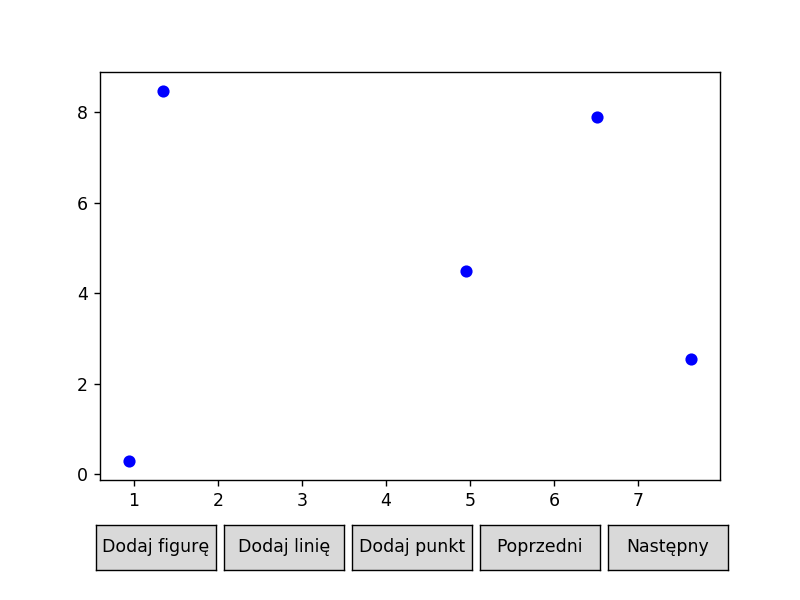

In [29]:
points = randomFirst(5,0,10)
v = Voronoi()
steps=v.create_diagram(points)
v.get_info()
plotx=Plot(steps)
plotx.draw()